In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import decomposition
from sklearn.model_selection import train_test_split
import time
import os
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [3]:
X=np.load('./npy_covid64/x_train.npy')
Y=np.load('./npy_covid64/y_train.npy')

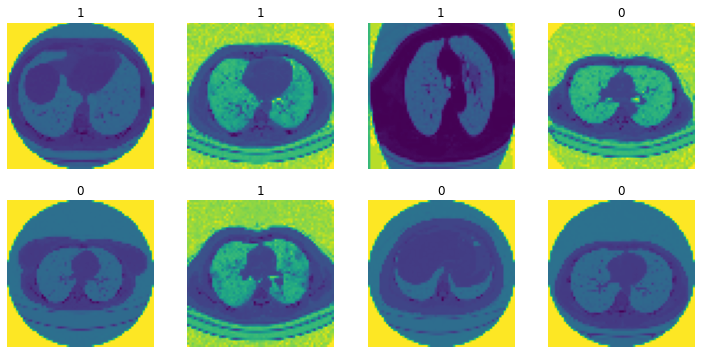

In [4]:
plt.figure(figsize=(10,10))
for i in range(0, 8):
    plt.subplot(440 + 1 + i)
    plt.tight_layout()
    plt.imshow(X[i*100], cmap=plt.get_cmap())
    plt.axis('off')
    plt.title(Y[i*100].argmax())    
plt.show()

In [5]:
X.shape

(11588, 64, 64)

In [6]:
Y.shape

(11588, 2)

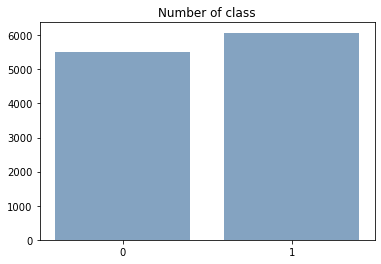

In [7]:
num_class = np.unique(Y.argmax(axis=1), return_counts=True) 
plt.title("Number of class")
plt.xticks(num_class[0])
plt.bar(num_class[0], num_class[1],color = (0.2, 0.4, 0.6, 0.6) )
plt.show()

In [8]:
X_flat = np.array(X).reshape((-1, 64*64))
X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.4, random_state=42)

In [9]:
X_flat.shape

(11588, 4096)

In [10]:
#Principle Componenet Analysis (PCA)

In [11]:
from sklearn.decomposition import PCA
pca_dims = PCA()
pca_dims.fit(X_flat)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.87) + 1
d

59

In [12]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_flat)
X_recovered = pca.inverse_transform(X_reduced)

In [13]:
print("reduced shape: " + str(X_reduced.shape))
print("recovered shape: " + str(X_recovered.shape))

reduced shape: (11588, 59)
recovered shape: (11588, 4096)


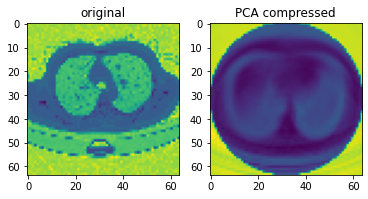

In [14]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_train[0].reshape((64,64)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_recovered[0].reshape((64,64)))
plt.show(block=True)

In [15]:
X = X.reshape(-1, 64, 64, 1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=20)

In [16]:
X_train.shape

(9270, 64, 64, 1)

In [17]:
y_train.shape

(9270, 2)

In [18]:
# Convert Images to Gray scale

In [19]:
X_train = X_train /255
X_test = X_test/255

In [20]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,Convolution2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Create Model

In [21]:
import keras
from keras import layers,models
from keras.layers import BatchNormalization

from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense,Dropout
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop, Adam

In [22]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [23]:
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(68, (5, 5), input_shape = (64, 64, 1), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(68, (5, 5), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))


classifier.add(Conv2D(68, (5, 5), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
#classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(Dropout(0.5))

classifier.add(Flatten())
classifier.add(BatchNormalization())
classifier.add(Dense(units = 2, activation = 'softmax'))

# Compiling the CNN

classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [24]:
from keras.preprocessing.image import ImageDataGenerator

# Generate Images
train_datagen = ImageDataGenerator(
                                   shear_range = 0.08,
                                   zoom_range = 0.08,
                                   horizontal_flip = False,
                                   width_shift_range= 0.02,
                                   height_shift_range= 0.02)
test_datagen = ImageDataGenerator(rescale = 1./255)

# fit parameters from data
training_set = train_datagen.flow(X_train, y_train, batch_size=10)
test_set = test_datagen.flow(X_test, y_test, batch_size=10)

start = time.time() # Measuring the processing time
history = classifier.fit_generator(training_set,
                         steps_per_epoch = 50,
                         epochs =100,
                         validation_data = test_set,
                         validation_steps = 10,
                         verbose=2)
end = time.time()
print(end - start)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
50/50 - 4s - loss: 0.6919 - accuracy: 0.5060 - val_loss: 0.6938 - val_accuracy: 0.4900
Epoch 2/100
50/50 - 4s - loss: 0.6849 - accuracy: 0.5480 - val_loss: 0.6873 - val_accuracy: 0.5900
Epoch 3/100
50/50 - 4s - loss: 0.6536 - accuracy: 0.6660 - val_loss: 0.6925 - val_accuracy: 0.5200
Epoch 4/100
50/50 - 4s - loss: 0.6642 - accuracy: 0.6620 - val_loss: 0.6926 - val_accuracy: 0.5200
Epoch 5/100
50/50 - 4s - loss: 0.6245 - accuracy: 0.7120 - val_loss: 0.6933 - val_accuracy: 0.4800
Epoch 6/100
50/50 - 4s - loss: 0.5892 - accuracy: 0.7400 - val_loss: 0.6969 - val_accuracy: 0.4900
Epoch 7/100
50/50 - 4s - loss: 0.6475 - accuracy: 0.7080 - val_loss: 0.7050 - val_accuracy: 0.4700
Epoch 8/100
50/50 - 4s - loss: 0.6176 - accuracy: 0.7300 - val_loss: 0.7018 - val_accuracy: 0.4800
Epoch 9/100
50/50 - 4s - loss: 0.6376 - accuracy: 0.6900 - val_loss: 0.6938 - val_accuracy: 0.5400
Epoch 10/100
50/50 - 4s - loss: 0

Epoch 81/100
50/50 - 4s - loss: 0.3959 - accuracy: 0.8200 - val_loss: 2.8303 - val_accuracy: 0.6400
Epoch 82/100
50/50 - 4s - loss: 0.4351 - accuracy: 0.7940 - val_loss: 3.7341 - val_accuracy: 0.5900
Epoch 83/100
50/50 - 4s - loss: 0.4076 - accuracy: 0.8080 - val_loss: 3.4464 - val_accuracy: 0.5000
Epoch 84/100
50/50 - 4s - loss: 0.3919 - accuracy: 0.8360 - val_loss: 3.4998 - val_accuracy: 0.4400
Epoch 85/100
50/50 - 4s - loss: 0.4088 - accuracy: 0.8340 - val_loss: 3.0276 - val_accuracy: 0.4900
Epoch 86/100
50/50 - 4s - loss: 0.3730 - accuracy: 0.8480 - val_loss: 3.3569 - val_accuracy: 0.5100
Epoch 87/100
50/50 - 4s - loss: 0.3742 - accuracy: 0.8540 - val_loss: 3.1851 - val_accuracy: 0.5500
Epoch 88/100
50/50 - 4s - loss: 0.4181 - accuracy: 0.8200 - val_loss: 2.1305 - val_accuracy: 0.5900
Epoch 89/100
50/50 - 4s - loss: 0.4216 - accuracy: 0.8100 - val_loss: 3.8119 - val_accuracy: 0.5100
Epoch 90/100
50/50 - 4s - loss: 0.3777 - accuracy: 0.8420 - val_loss: 2.5644 - val_accuracy: 0.5500


In [25]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 68)        1768      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 68)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 68)        115668    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 68)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 68)          115668    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 68)          0         
_________________________________________________________________
dense (Dense)                (None, 4, 4, 256)         1

In [26]:
scores = classifier.evaluate(X_test, y_test, verbose=1)
print("{}: {:.2f}%".format(classifier.metrics_names[1], scores[1]*100))

73/73 [==============================] - 4s 57ms/step - loss: 0.4612 - accuracy: 0.7908
accuracy: 79.08%


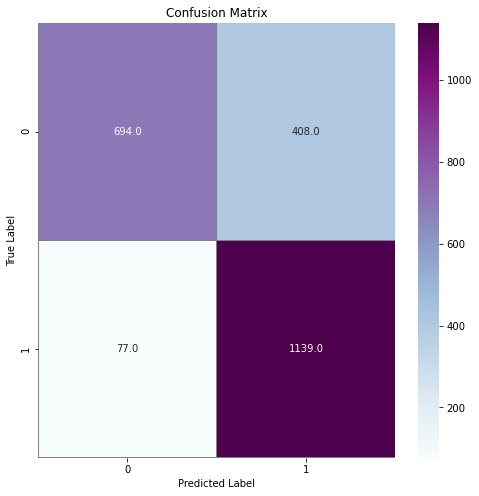

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 
# Predict the values from the validation dataset
Y_pred = classifier.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



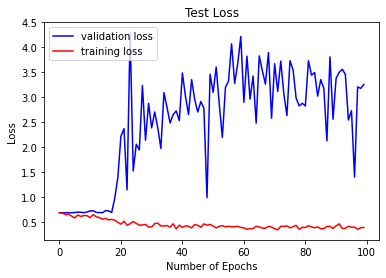

In [28]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='r', label="training loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

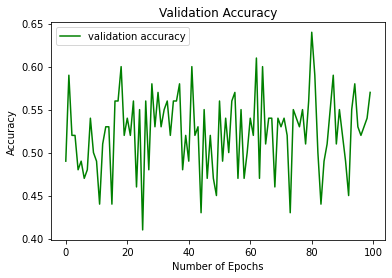

In [29]:
# Plot the accuracy curve for validation 
plt.plot(history.history['val_accuracy'], color='g', label="validation accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [30]:
classifier.save('cnn_weights_2.h5')

In [31]:
classifier.load_weights('cnn_weights_2.h5')

In [32]:
model_feat = Model(inputs=classifier.input,outputs=classifier.get_layer('dense_1').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

#feat_val = model_feat.predict(x_val)
#print(feat_val.shape)

feat_test = model_feat.predict(X_test)
print(feat_test.shape)

(9270, 2)
(2318, 2)


In [33]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')
start = time.time() # Measuring the processing time
svm.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)
print('fitting done !!!')

fitting done !!!


In [34]:
print(end - start)

1.539910078048706


In [35]:
svm.score(feat_train,np.argmax(y_train,axis=1))

0.8606256742179073

In [36]:
svm.score(feat_test,np.argmax(y_test,axis=1))

0.8490077653149266

In [37]:
Pred_labels = svm.predict(feat_test)

# Applying XGBOOST

In [38]:
import xgboost as xgb

xb = xgb.XGBClassifier()
start = time.time() # Measuring the processing time
xb.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)
print('fitting done !!!')

fitting done !!!


In [39]:
print(end - start)

0.24534320831298828


In [40]:
xb.score(feat_train,np.argmax(y_train,axis=1))

0.8715210355987055

In [41]:
xb.score(feat_test,np.argmax(y_test,axis=1))

0.8520276100086281

In [42]:
Pred_labels = xb.predict(feat_test)

In [43]:
import seaborn as sns

In [44]:
def plot_heatmap(cm,title):
    df_cm2 = pd.DataFrame(cm, index = ['No Covid','Covid'])
    df_cm2.columns=['No Covid','Covid']
    f,ax = plt.subplots(figsize=(12, 12))
    #ax = plt.axes()
    sns.heatmap(df_cm2, annot=True, fmt="d", linewidths=.5,ax=ax)
    ax.set_title(title)
    plt.show()    
    return

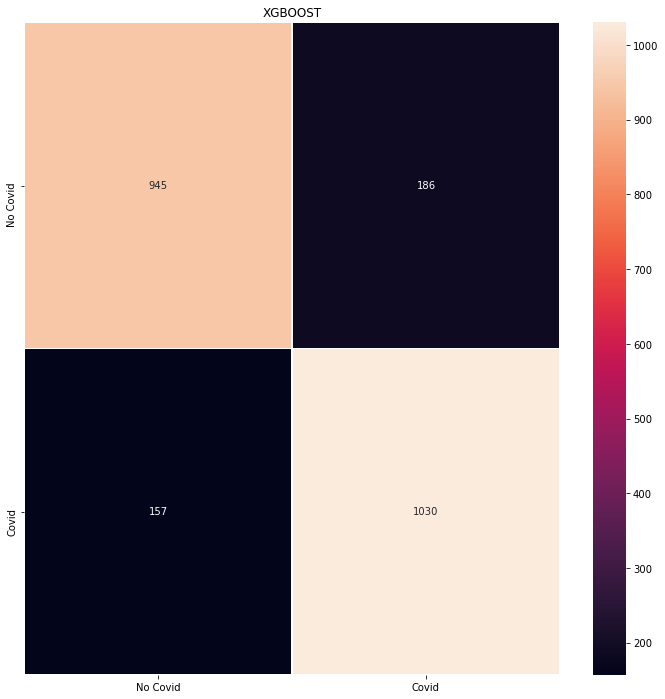

In [45]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'XGBOOST')

In [46]:
from sklearn.metrics import classification_report
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

              precision    recall  f1-score   support

           0     0.8575    0.8355    0.8464      1131
           1     0.8470    0.8677    0.8573      1187

    accuracy                         0.8520      2318
   macro avg     0.8523    0.8516    0.8518      2318
weighted avg     0.8522    0.8520    0.8520      2318



In [48]:
Pred_labels = svm.predict(feat_test)

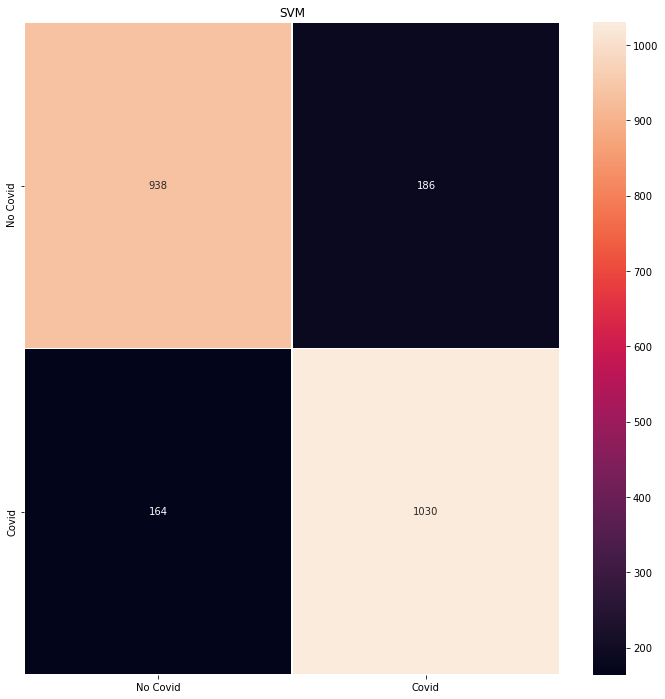

In [49]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'SVM')

In [50]:
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

              precision    recall  f1-score   support

           0     0.8512    0.8345    0.8428      1124
           1     0.8470    0.8626    0.8548      1194

    accuracy                         0.8490      2318
   macro avg     0.8491    0.8486    0.8488      2318
weighted avg     0.8490    0.8490    0.8490      2318



In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection

In [52]:
lr = LogisticRegression()
start = time.time() # Measuring the processing time
lr.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print('fitting done !!!')

fitting done !!!


In [53]:
print(end - start) # Total 

0.015971660614013672


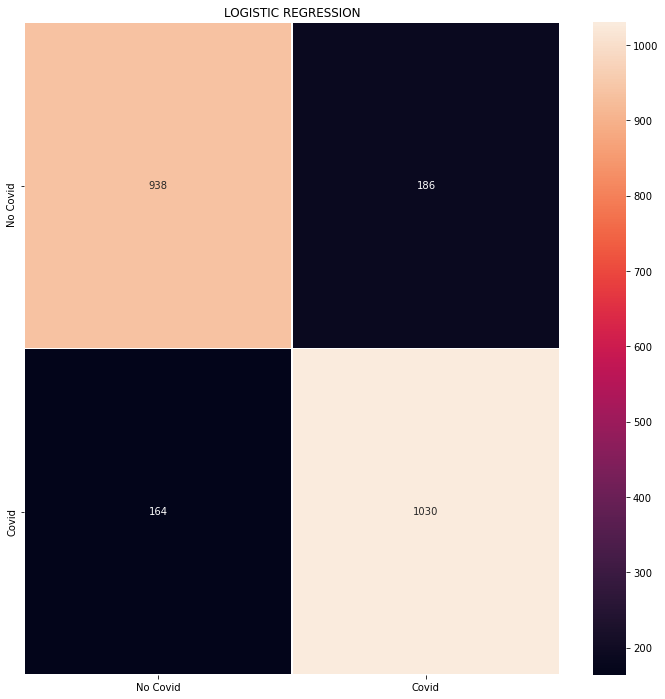

In [54]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'LOGISTIC REGRESSION')

In [55]:
Pred_labels = lr.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

              precision    recall  f1-score   support

           0     0.7995    0.8646    0.8307      1019
           1     0.8865    0.8299    0.8573      1299

    accuracy                         0.8451      2318
   macro avg     0.8430    0.8472    0.8440      2318
weighted avg     0.8482    0.8451    0.8456      2318



In [56]:
dt = DecisionTreeClassifier()
start = time.time() # Measuring the processing time
dt.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 
print('fitting done !!!')
Pred_labels = dt.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

0.02695918083190918
fitting done !!!
              precision    recall  f1-score   support

           0     0.8158    0.8034    0.8095      1119
           1     0.8191    0.8307    0.8248      1199

    accuracy                         0.8175      2318
   macro avg     0.8174    0.8170    0.8172      2318
weighted avg     0.8175    0.8175    0.8175      2318



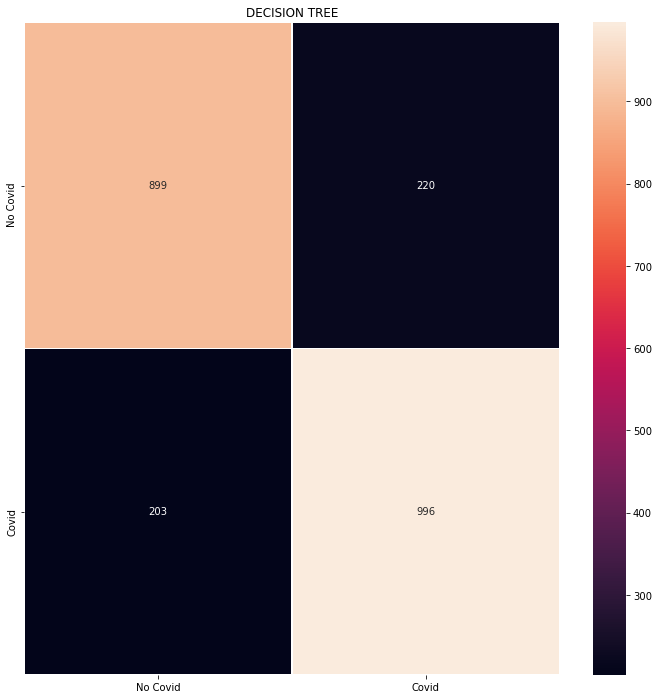

In [57]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'DECISION TREE')

In [58]:
knn = KNeighborsClassifier()
start = time.time() # Measuring the processing time
knn.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 

print('fitting done !!!')
Pred_labels = knn.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

0.010005474090576172
fitting done !!!
              precision    recall  f1-score   support

           0     0.8584    0.8155    0.8364      1160
           1     0.8240    0.8653    0.8441      1158

    accuracy                         0.8404      2318
   macro avg     0.8412    0.8404    0.8403      2318
weighted avg     0.8412    0.8404    0.8403      2318



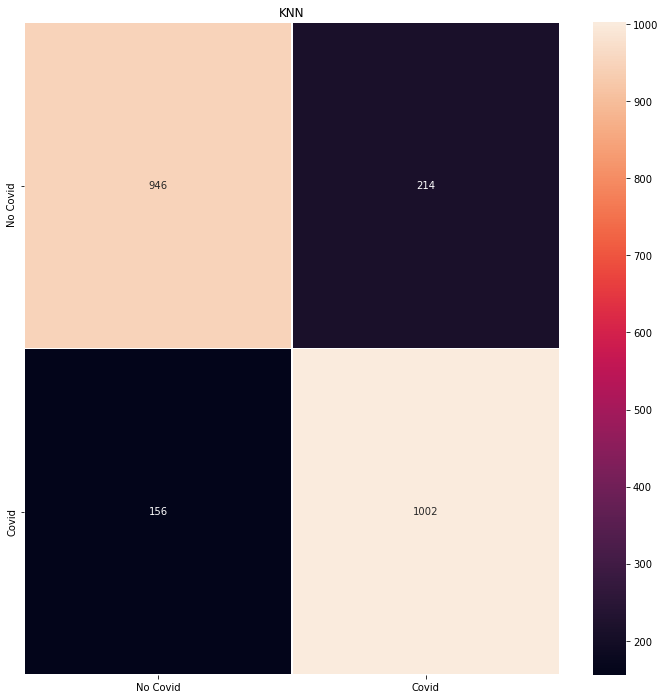

In [59]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'KNN')

In [60]:
lda = LinearDiscriminantAnalysis()
start = time.time() # Measuring the processing time
lda.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 

print('fitting done !!!')
Pred_labels = lda.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

0.11743831634521484
fitting done !!!
              precision    recall  f1-score   support

           0     0.7786    0.8702    0.8218       986
           1     0.8947    0.8168    0.8540      1332

    accuracy                         0.8395      2318
   macro avg     0.8367    0.8435    0.8379      2318
weighted avg     0.8453    0.8395    0.8403      2318



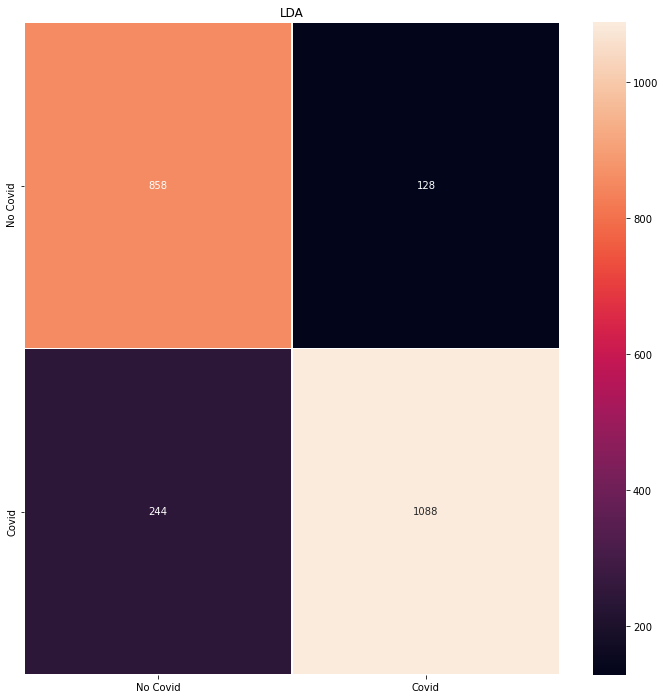

In [61]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'LDA')

In [62]:
nb = GaussianNB()
start = time.time() # Measuring the processing time
nb.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 

print('fitting done !!!')
Pred_labels = nb.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

0.0034704208374023438
fitting done !!!
              precision    recall  f1-score   support

           0     0.7868    0.8705    0.8265       996
           1     0.8939    0.8222    0.8566      1322

    accuracy                         0.8430      2318
   macro avg     0.8403    0.8464    0.8415      2318
weighted avg     0.8479    0.8430    0.8437      2318



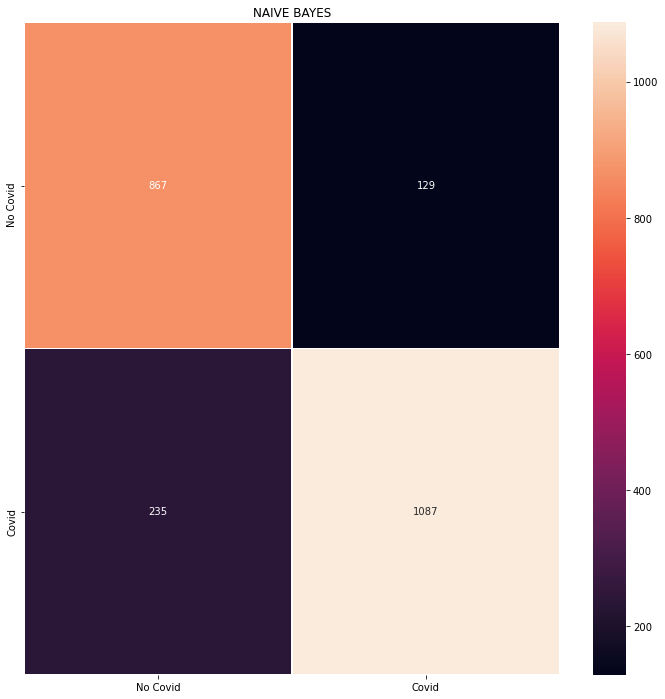

In [63]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'NAIVE BAYES')

In [64]:
et = ExtraTreesClassifier()
start = time.time() # Measuring the processing time
et.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

0.6239345073699951
fitting done !!!
              precision    recall  f1-score   support

           0     0.8185    0.8061    0.8122      1119
           1     0.8215    0.8332    0.8273      1199

    accuracy                         0.8201      2318
   macro avg     0.8200    0.8196    0.8198      2318
weighted avg     0.8201    0.8201    0.8200      2318



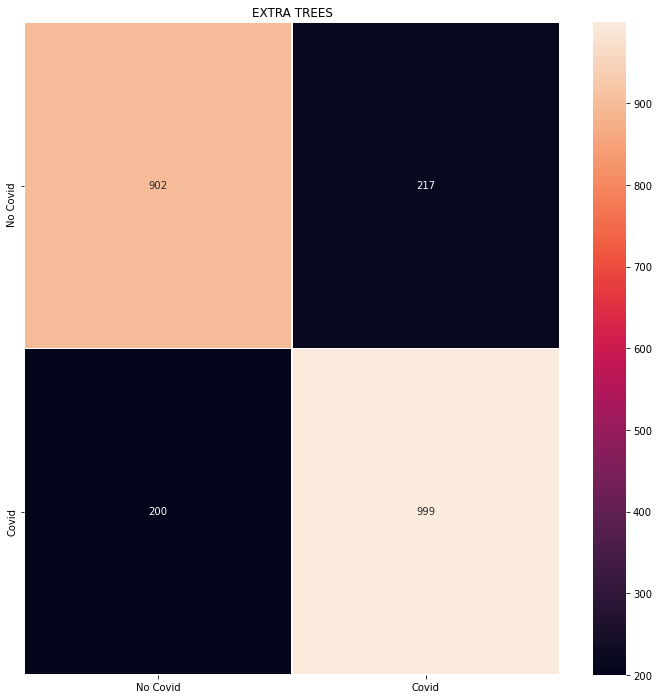

In [65]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'EXTRA TREES')

In [70]:
rf = RandomForestClassifier()
start = time.time() # Measuring the processing time
rf.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

1.0054585933685303
fitting done !!!
              precision    recall  f1-score   support

           0     0.8185    0.8061    0.8122      1119
           1     0.8215    0.8332    0.8273      1199

    accuracy                         0.8201      2318
   macro avg     0.8200    0.8196    0.8198      2318
weighted avg     0.8201    0.8201    0.8200      2318



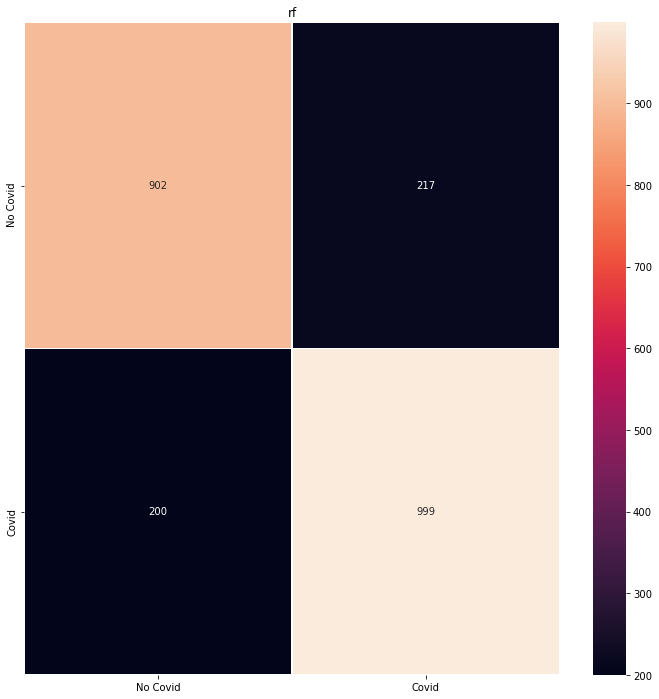

In [72]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'rf')

In [73]:
import lightgbm as lgb

In [75]:
lg = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
start = time.time() # Measuring the processing time
lg.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

0.08379912376403809
fitting done !!!
              precision    recall  f1-score   support

           0     0.8185    0.8061    0.8122      1119
           1     0.8215    0.8332    0.8273      1199

    accuracy                         0.8201      2318
   macro avg     0.8200    0.8196    0.8198      2318
weighted avg     0.8201    0.8201    0.8200      2318



In [76]:
from catboost import CatBoostClassifier

In [77]:
cb = CatBoostClassifier()
start = time.time() # Measuring the processing time
cb.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

Learning rate set to 0.026661
0:	learn: 0.6662893	total: 272ms	remaining: 4m 32s
1:	learn: 0.6399575	total: 277ms	remaining: 2m 18s
2:	learn: 0.6192399	total: 281ms	remaining: 1m 33s
3:	learn: 0.5983691	total: 285ms	remaining: 1m 11s
4:	learn: 0.5798252	total: 290ms	remaining: 57.6s
5:	learn: 0.5625965	total: 294ms	remaining: 48.6s
6:	learn: 0.5468106	total: 298ms	remaining: 42.2s
7:	learn: 0.5333892	total: 302ms	remaining: 37.4s
8:	learn: 0.5202003	total: 306ms	remaining: 33.7s
9:	learn: 0.5075566	total: 310ms	remaining: 30.7s
10:	learn: 0.4959867	total: 315ms	remaining: 28.3s
11:	learn: 0.4851323	total: 319ms	remaining: 26.2s
12:	learn: 0.4751186	total: 323ms	remaining: 24.5s
13:	learn: 0.4663050	total: 327ms	remaining: 23.1s
14:	learn: 0.4574075	total: 332ms	remaining: 21.8s
15:	learn: 0.4497901	total: 336ms	remaining: 20.7s
16:	learn: 0.4421996	total: 340ms	remaining: 19.7s
17:	learn: 0.4355698	total: 344ms	remaining: 18.8s
18:	learn: 0.4295742	total: 349ms	remaining: 18s
19:	learn

193:	learn: 0.3327979	total: 1.13s	remaining: 4.71s
194:	learn: 0.3327743	total: 1.14s	remaining: 4.71s
195:	learn: 0.3327512	total: 1.15s	remaining: 4.7s
196:	learn: 0.3327348	total: 1.15s	remaining: 4.7s
197:	learn: 0.3327195	total: 1.16s	remaining: 4.68s
198:	learn: 0.3327147	total: 1.16s	remaining: 4.67s
199:	learn: 0.3327020	total: 1.17s	remaining: 4.66s
200:	learn: 0.3326627	total: 1.17s	remaining: 4.65s
201:	learn: 0.3326437	total: 1.17s	remaining: 4.64s
202:	learn: 0.3326372	total: 1.18s	remaining: 4.63s
203:	learn: 0.3326201	total: 1.18s	remaining: 4.62s
204:	learn: 0.3326078	total: 1.19s	remaining: 4.61s
205:	learn: 0.3326039	total: 1.19s	remaining: 4.59s
206:	learn: 0.3325808	total: 1.2s	remaining: 4.58s
207:	learn: 0.3325734	total: 1.2s	remaining: 4.57s
208:	learn: 0.3325647	total: 1.2s	remaining: 4.56s
209:	learn: 0.3325555	total: 1.21s	remaining: 4.55s
210:	learn: 0.3325426	total: 1.21s	remaining: 4.53s
211:	learn: 0.3325256	total: 1.22s	remaining: 4.52s
212:	learn: 0.332

352:	learn: 0.3306275	total: 1.83s	remaining: 3.36s
353:	learn: 0.3306104	total: 1.84s	remaining: 3.35s
354:	learn: 0.3305813	total: 1.84s	remaining: 3.35s
355:	learn: 0.3305615	total: 1.85s	remaining: 3.34s
356:	learn: 0.3305470	total: 1.85s	remaining: 3.33s
357:	learn: 0.3305433	total: 1.86s	remaining: 3.33s
358:	learn: 0.3305227	total: 1.86s	remaining: 3.32s
359:	learn: 0.3305047	total: 1.86s	remaining: 3.32s
360:	learn: 0.3304802	total: 1.87s	remaining: 3.31s
361:	learn: 0.3304643	total: 1.87s	remaining: 3.3s
362:	learn: 0.3304476	total: 1.88s	remaining: 3.3s
363:	learn: 0.3304347	total: 1.88s	remaining: 3.29s
364:	learn: 0.3304055	total: 1.89s	remaining: 3.28s
365:	learn: 0.3303887	total: 1.89s	remaining: 3.28s
366:	learn: 0.3303646	total: 1.9s	remaining: 3.27s
367:	learn: 0.3303427	total: 1.9s	remaining: 3.27s
368:	learn: 0.3303229	total: 1.91s	remaining: 3.26s
369:	learn: 0.3303094	total: 1.91s	remaining: 3.25s
370:	learn: 0.3302933	total: 1.92s	remaining: 3.25s
371:	learn: 0.33

549:	learn: 0.3264992	total: 2.72s	remaining: 2.23s
550:	learn: 0.3264874	total: 2.73s	remaining: 2.22s
551:	learn: 0.3264724	total: 2.73s	remaining: 2.22s
552:	learn: 0.3264559	total: 2.74s	remaining: 2.21s
553:	learn: 0.3264304	total: 2.74s	remaining: 2.21s
554:	learn: 0.3264166	total: 2.75s	remaining: 2.2s
555:	learn: 0.3263877	total: 2.75s	remaining: 2.2s
556:	learn: 0.3263777	total: 2.76s	remaining: 2.19s
557:	learn: 0.3263670	total: 2.76s	remaining: 2.19s
558:	learn: 0.3263573	total: 2.77s	remaining: 2.18s
559:	learn: 0.3263402	total: 2.77s	remaining: 2.18s
560:	learn: 0.3263118	total: 2.77s	remaining: 2.17s
561:	learn: 0.3262958	total: 2.78s	remaining: 2.17s
562:	learn: 0.3262727	total: 2.78s	remaining: 2.16s
563:	learn: 0.3262497	total: 2.79s	remaining: 2.15s
564:	learn: 0.3262270	total: 2.79s	remaining: 2.15s
565:	learn: 0.3262033	total: 2.8s	remaining: 2.14s
566:	learn: 0.3261886	total: 2.8s	remaining: 2.14s
567:	learn: 0.3261746	total: 2.81s	remaining: 2.13s
568:	learn: 0.32

744:	learn: 0.3232741	total: 3.61s	remaining: 1.24s
745:	learn: 0.3232623	total: 3.61s	remaining: 1.23s
746:	learn: 0.3232549	total: 3.62s	remaining: 1.23s
747:	learn: 0.3232469	total: 3.62s	remaining: 1.22s
748:	learn: 0.3232404	total: 3.63s	remaining: 1.22s
749:	learn: 0.3232331	total: 3.63s	remaining: 1.21s
750:	learn: 0.3232255	total: 3.64s	remaining: 1.21s
751:	learn: 0.3232137	total: 3.64s	remaining: 1.2s
752:	learn: 0.3232000	total: 3.65s	remaining: 1.2s
753:	learn: 0.3231902	total: 3.65s	remaining: 1.19s
754:	learn: 0.3231797	total: 3.65s	remaining: 1.19s
755:	learn: 0.3231640	total: 3.66s	remaining: 1.18s
756:	learn: 0.3231484	total: 3.66s	remaining: 1.18s
757:	learn: 0.3231425	total: 3.67s	remaining: 1.17s
758:	learn: 0.3231345	total: 3.67s	remaining: 1.17s
759:	learn: 0.3231217	total: 3.68s	remaining: 1.16s
760:	learn: 0.3231118	total: 3.68s	remaining: 1.16s
761:	learn: 0.3231057	total: 3.69s	remaining: 1.15s
762:	learn: 0.3230917	total: 3.69s	remaining: 1.15s
763:	learn: 0.

903:	learn: 0.3216396	total: 4.32s	remaining: 459ms
904:	learn: 0.3216323	total: 4.33s	remaining: 454ms
905:	learn: 0.3216198	total: 4.33s	remaining: 450ms
906:	learn: 0.3216095	total: 4.34s	remaining: 445ms
907:	learn: 0.3215980	total: 4.34s	remaining: 440ms
908:	learn: 0.3215892	total: 4.35s	remaining: 435ms
909:	learn: 0.3215722	total: 4.35s	remaining: 431ms
910:	learn: 0.3215643	total: 4.36s	remaining: 426ms
911:	learn: 0.3215592	total: 4.36s	remaining: 421ms
912:	learn: 0.3215461	total: 4.37s	remaining: 416ms
913:	learn: 0.3215341	total: 4.37s	remaining: 411ms
914:	learn: 0.3215245	total: 4.38s	remaining: 407ms
915:	learn: 0.3215181	total: 4.38s	remaining: 402ms
916:	learn: 0.3215124	total: 4.38s	remaining: 397ms
917:	learn: 0.3215067	total: 4.39s	remaining: 392ms
918:	learn: 0.3215011	total: 4.39s	remaining: 387ms
919:	learn: 0.3214922	total: 4.4s	remaining: 382ms
920:	learn: 0.3214811	total: 4.4s	remaining: 378ms
921:	learn: 0.3214768	total: 4.41s	remaining: 373ms
922:	learn: 0.

In [66]:
estimators = list()
estimators.append(('RF', RandomForestClassifier()))
estimators.append(('LR', LogisticRegression()))
estimators.append(('DTC', DecisionTreeClassifier()))
estimators.append(('KNN', KNeighborsClassifier()))
estimators.append(('LDA', LinearDiscriminantAnalysis()))
estimators.append(('NB', GaussianNB()))
#estimators.append(('SVM', GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , subsample=0.95, random_state=10)))
estimators.append(('XGB', XGBClassifier()))

In [67]:
ensemble = VotingClassifier(estimators=estimators, voting='soft')
start = time.time() # Measuring the processing time
ensemble.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = ensemble.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

1.2679660320281982
fitting done !!!
              precision    recall  f1-score   support

           0     0.8321    0.8452    0.8386      1085
           1     0.8618    0.8500    0.8559      1233

    accuracy                         0.8477      2318
   macro avg     0.8470    0.8476    0.8472      2318
weighted avg     0.8479    0.8477    0.8478      2318



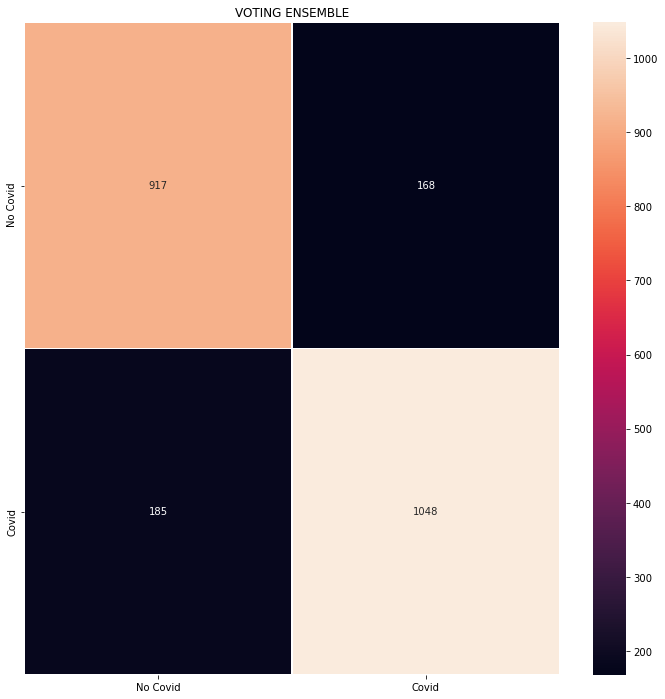

In [68]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'VOTING ENSEMBLE')

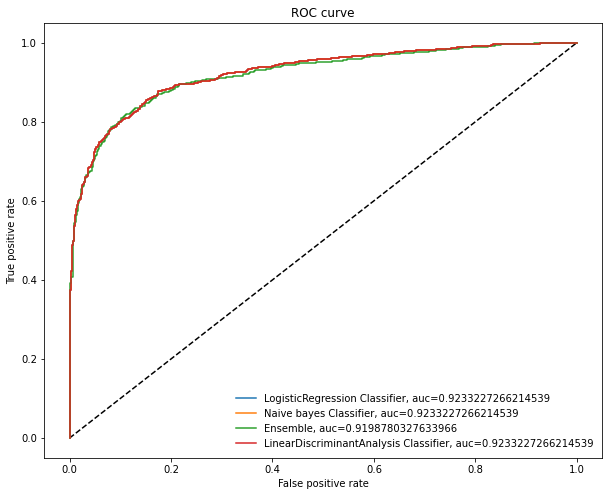

In [69]:
from sklearn import metrics
from sklearn.metrics import roc_curve


clf2=LogisticRegression().fit(feat_train,np.argmax(y_train,axis=1))
y_pred2 = clf2.predict(feat_test)

clf3 = GaussianNB().fit(feat_train,np.argmax(y_train,axis=1))
y_pred3 = clf3.predict(feat_test)

clf4 = ensemble.fit(feat_train,np.argmax(y_train,axis=1))
y_pred4 = clf4.predict(feat_test)

clf6=LinearDiscriminantAnalysis().fit(feat_train,np.argmax(y_train,axis=1))
y_pred6 = clf6.predict(feat_test)

#clf7=SVC(kernel='rbf').fit(feat_train,np.argmax(y_train,axis=1))
#y_pred7 = clf7.predict(feat_test)

y_pred_proba2 = clf2.predict_proba(feat_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba2)
auc2 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba2)

y_pred_proba3 = clf3.predict_proba(feat_test)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba3)
auc3 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba3)

y_pred_proba4 = clf4.predict_proba(feat_test)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba4)
auc4 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba4)

y_pred_proba6 = clf6.predict_proba(feat_test)[::,1]
fpr6, tpr6, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba6)
auc6 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba6)

#y_pred_proba7 = clf7.predict_proba(feat_test)[::,1]
#fpr7, tpr7, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba7)
#auc7 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba7)


plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2,tpr2,label="LogisticRegression Classifier, auc="+str(auc2))
plt.plot(fpr3,tpr3,label="Naive bayes Classifier, auc="+str(auc3))
plt.plot(fpr4,tpr4,label="Ensemble, auc="+str(auc4))
plt.plot(fpr6,tpr6,label="LinearDiscriminantAnalysis Classifier, auc="+str(auc6))
#plt.plot(fpr7,tpr7,label="SVC Classifier, auc="+str(auc7))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(frameon=False)
plt.show()